In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pylab as pl
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.init as init
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [88]:
# 加载数据
Data_ = pd.read_csv(r'C:\Users\JIBINBIN\ADA/FINNAL/3_phrase/3Phrase_FlightData.csv')

In [89]:
# 归一化处理
sc_data = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))

data_ = Data_.drop(columns=['Unnamed: 0','FLIGHT_PHASE','FF1C','FF2C'],axis=1).copy()
data_y = Data_[['FF']].copy()
data_sc = sc_data.fit_transform(data_)
sc_y.fit(data_y)

MinMaxScaler()

In [90]:
data_label = data_.columns.values
data_dic = dict(zip(data_label,data_sc.T))
data_df = pd.DataFrame(data_dic)
data_df.head(5)

,FLIGHT_NO2,ALT_STDC,TAS,GWC,N11,N21,CK_EGT1,N12,N22,CK_EGT2,WIN_SPD,WIN_DIR,SAT,PITCH,VRTG,LONG,FF
0,0.0,0.033689,0.038358,0.953144,0.928467,0.887255,0.924242,0.928467,0.889976,0.908861,0.132812,0.707752,0.860979,0.594595,0.205508,0.908910,0.959025
1,0.0,0.033841,0.046030,0.953144,0.929927,0.889706,0.926768,0.929927,0.889976,0.908861,0.132812,0.707752,0.860979,0.594595,0.288136,0.921875,0.958249
2,0.0,0.034146,0.053702,0.953144,0.934307,0.889706,0.926768,0.934307,0.892421,0.913924,0.132812,0.707752,0.857820,0.567568,0.288136,0.921875,0.970045
3,0.0,0.034451,0.064058,0.953144,0.937226,0.892157,0.931818,0.937226,0.894866,0.916456,0.132812,0.707752,0.857820,0.594595,0.387712,0.921875,0.976564
4,0.0,0.034909,0.067894,0.953144,0.938686,0.892157,0.931818,0.938686,0.894866,0.916456,0.125000,0.701896,0.857820,0.594595,0.470339,0.934840,0.983082


In [91]:
# 拆分训练集和测试集，这里以3架航班的数据作为训练集，一架航班的数据作为测试集。
Flight_Number = data_df['FLIGHT_NO2'].unique()
Train = data_df[data_df['FLIGHT_NO2']!=Flight_Number[-1]]
Test = data_df[data_df['FLIGHT_NO2']==Flight_Number[-1]]

In [105]:
def create_seq(input_data, tw):
    inout_seq = []
    F_NO = input_data['FLIGHT_NO2'].unique()
    for f in F_NO:
        in_data = input_data[input_data['FLIGHT_NO2']==f].reset_index(drop=True)
        in_data_x = in_data.drop(columns=['FLIGHT_NO2','FF'],axis=1).copy()
        in_data_y = in_data['FF'].copy()
        L = len(in_data)
        for i in range(L-tw+1):
            train_seq = in_data_x[i:i+tw]
            train_seq = torch.tensor(data=train_seq.values).type(torch.float32).to(device)
            train_label = in_data_y[i+tw-1]
            train_label = torch.tensor(data=train_label).type(torch.float32).to(device)
            inout_seq.append((train_seq ,train_label))
    
    return inout_seq

In [159]:
# 模型构建
class LSTM(nn.Module):
    def __init__(self,
                 hidden_layer_size
                 input_size=data_df.shape[1] - 2,
                 layer_num=1,
                 output_size=1):
        super(LSTM, self).__init__()
        #填写程序
        self.layer_num = layer_num
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.RNN(input_size,
                            hidden_layer_size,
                            layer_num,
                            batch_first=True,
                            bidirectional=False)
        self.output = nn.Sequential(
            nn.Linear(hidden_layer_size, 32),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        init_lstm(self.lstm)

    def attention_net(self, lstm_output, final_state):
        # lstm_output [B,tw,hidden]
        # final_state [1,B,hidden] -> [B,hidden,1]
        # atten_w [B,tw,1]

        #          [1,B,hidden]->[B,1,hidden]
        hidden = final_state.transpose(0, 1)
        #         [B,1,hidden]->[B,hidden,1]
        hidden = hidden.transpose(1, 2)
        #         final_state [B,hidden,1]

        attn_weights = torch.bmm(lstm_output, hidden)
        # atten_w [B,tw]
        soft_attn_weights = F.softmax(attn_weights, 1)

        # lstm_output [B,tw,hidden] -> [B,hidden,tw]
        # soft_attn_weights [B,tw,1]
        # Atten_value [B,hidden]
        Attened_value = torch.bmm(lstm_output.transpose(1, 2),
                                  soft_attn_weights).squeeze(2)

        return Attened_value, soft_attn_weights

    def forward(self, input_seq):
        #填写程序
        #         print(input_seq.size())
        #         [B,tw,feature_len]
        input_seq = input_seq.reshape(-1, tw, self.input_size)
        #         print(input_seq.size()

        out,hn = self.lstm(input_seq)
#         Attened_value, soft_attn_weights = self.attention_net(out, hn)
        atten_res = self.output(hn.squeeze(0))
                                
        return atten_res


def init_lstm(x):
    """
    初始化网络权重
    LSTM 网络采tanh激活函数，使用Xavier初始化
    """
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                init.xavier_normal_(getattr(x, w))

In [165]:
# 将训练和预测的过程封装
class LSTM_Predction():
    def __init__(self, train_inout_seq, test_inout_seq,hidden_layer_size, lr, epo):
        self.train_inout_seq = train_inout_seq
        self.test_inout_seq = test_inout_seq
        self.epo = epo
        self.lr = lr
        self.model = LSTM(hidden_layer_size
                 input_size=data_df.shape[1] - 2,
                 layer_num=1,
                 output_size=1).to(device)
        self.loss_function = nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def train(self):
        data_loader = Data.DataLoader(dataset=self.train_inout_seq,
                                      batch_size=256,
                                      shuffle=False)
        # 模型设计
        Losslist = []
        y_pred = []
        for i in range(self.epo):
            Loss = []
            for batch_id, (seq, label) in enumerate(data_loader):
                self.optimizer.zero_grad()
                y_hat = self.model(seq)
                label = label.reshape(-1, 1)
                single_loss = self.loss_function(y_hat, label)
                single_loss.backward()
                self.optimizer.step()
                Loss.append(single_loss.item())
            L = np.mean(Loss)
            Losslist.append(L)
            if i % 1000 == 0:
                print(f'epoch: {i:3} loss: {L:10.8f}')

        print(f'epoch: {i:3} loss: {L.item():10.8f}')
    
        return L.item()

        # plt.plot(Losslist)
        # plt.show()

    def train_plot(self):
        y_pred_train = []
        y_true_train = []
        self.model.eval()  # 关闭dropout
        for i in range(len(self.train_inout_seq)):
            y_hat_train = self.model(self.train_inout_seq[i][0])
            y_pred_train.append(y_hat_train.item())
            y_true_train.append(self.train_inout_seq[i][1].item())

        # plt.figure(figsize=(20,10))
        # plt.scatter(np.arange(len(self.train_inout_seq)), y_pred_train,s=4)
        # plt.plot(np.arange(len(self.train_inout_seq)),y_true_train, 'r-', lw=2)
        # plt.show()

    def test(self):
        y_pred_test = []
        y_true_test = []
        pred_loss = []
        Atten_w_lst = []

        self.model.eval()  # 关闭dropout
        for i in range(len(self.test_inout_seq)):
            y_hat_test = self.model(self.test_inout_seq[i][0])
            y_pred_test.append(y_hat_test.item())
            y_true_test.append(self.test_inout_seq[i][1].item())
            single_loss = self.loss_function(y_hat_test, self.test_inout_seq[i][1].reshape(-1, 1))
            pred_loss.append(single_loss.item())

#         print(np.mean(pred_loss))

        return np.mean(pred_loss)

In [ ]:
tw = 8
train_inout_seq = create_seq(Train, tw)
test_inout_seq = create_seq(Test, tw)

In [ ]:
hidden=[i for i in range(5,16)]
seq=[5,8,10,13,15]
LR=[1e-2,1e-3,1e-4]

In [ ]:
train=[[] for i in range(len(seq))]
test=[[] for i in range(len(seq))]
hidden_size=15
for tw in seq:
    tw_i=0
    L_train=[]
    L_test=[]
    train_inout_seq = create_seq(Train, tw)
    test_inout_seq = create_seq(Test, tw)
    for lr in LR:
        L_train_=[]
        L_test_=[]
        for i in range(10):
            lstm_pred = LSTM_Predction(train_inout_seq, test_inout_seq,hidden_size lr,2000)
            train_loss = lstm_pred.train()
            L_train_.append(train_loss)
            
            # lstm_pred.train_plot()
            pred_loss = lstm_pred.test()
            L_test_.append(pred_loss)
            
    train[tw_i] = np.array(L_train_).mean
    test[tw_i] = np.array(L_test_).mean
    tw_i+=1
    
train = np.array(train).T
test = np.array(test).T

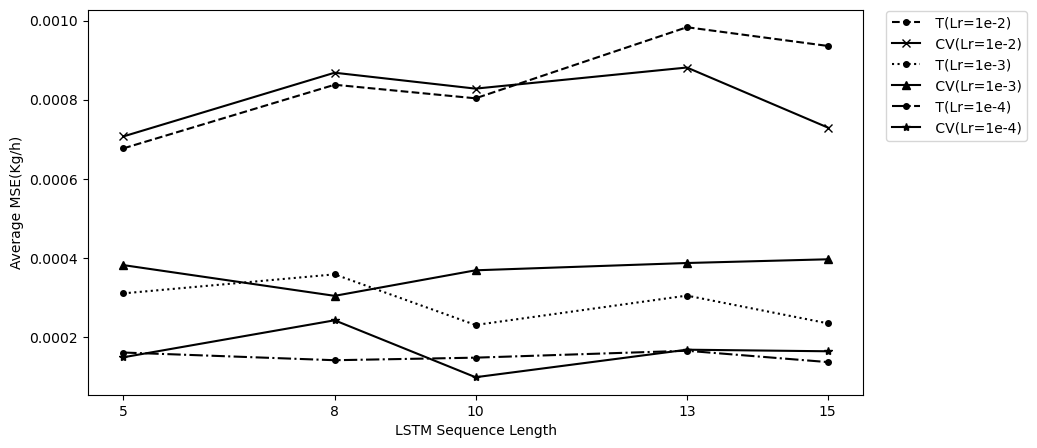

In [57]:
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
plt.figure(figsize=(10,5),dpi=100)
seq=[5,8,10,13,15]
lr=['1e-2','1e-3','1e-4']
plt.plot(seq, train[0],label=' T(Lr='+str(lr[0])+')',linestyle='--',marker='.',markersize=8,color='k')
plt.plot(seq, test[0],label=' CV(Lr='+str(lr[0])+')',marker='x',markersize=6,color='k')

plt.plot(seq, train[1],label=' T(Lr='+str(lr[1])+')',linestyle='dotted',marker='.',markersize=8,color='k')
plt.plot(seq, test[1],label=' CV(Lr='+str(lr[1])+')',marker='^',markersize=6,color='k')

plt.plot(seq, train[2],label=' T(Lr='+str(lr[2])+')',linestyle='dashdot',marker='.',markersize=8,color='k')
plt.plot(seq, test[2],label=' CV(Lr='+str(lr[2])+')',marker='*',markersize=6,color='k')

plt.xticks([5,8,10,13,15])
ax = plt.subplot()
ax.set_xlabel('LSTM Sequence Length',size=10)
ax.set_ylabel('Average MSE(Kg/h)',size=10)
plt.legend(bbox_to_anchor=(1.03, 0.66), loc=3, borderaxespad=0)
# plt.legend()
plt.savefig('./Pic1.png',dpi=300,bbox_inches = 'tight')
plt.show()

In [ ]:
train_inout_seq = create_seq(Train, 10)
test_inout_seq = create_seq(Test, 10)

In [ ]:
train=[]
test=[]
for h in hidden:
    L_train=[]
    L_test=[]
    for i in range(10):
        lstm_pred = LSTM_Predction(train_inout_seq, test_inout_seq,h,1e-4,2000)
        train_loss = lstm_pred.train()
        L_train.append(train_loss)
            
        # lstm_pred.train_plot()
        pred_loss = lstm_pred.test()
        L_test.append(pred_loss)
        
    train.append(np.array(L_train).mean)
    test.append(np.array(L_test).mean)

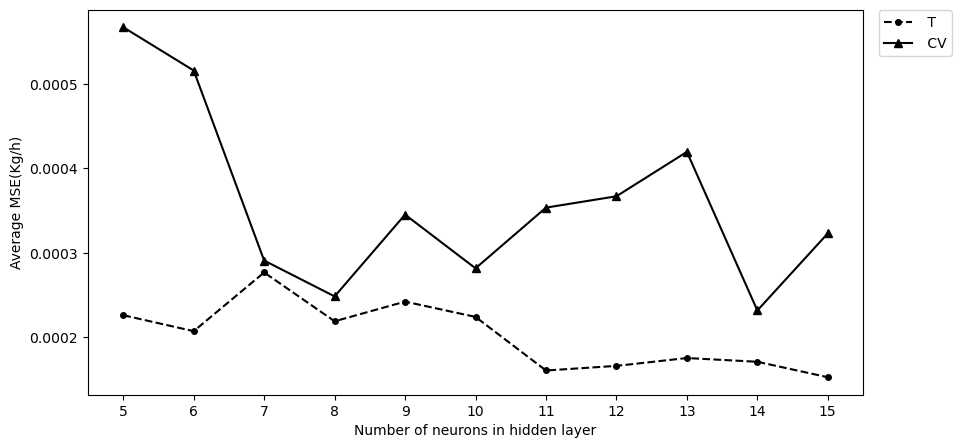

In [53]:
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties
plt.figure(figsize=(10,5),dpi=100)
hidden=[i for i in range(5,16)]

plt.plot(hidden, train,label=' T',linestyle='--',marker='.',markersize=8,color='k')
plt.plot(hidden, test,label=' CV',marker='^',markersize=6,color='k')

plt.xticks(seq)
ax = plt.subplot()
ax.set_xlabel('Number of neurons in hidden layer',size=10)
ax.set_ylabel('Average MSE(Kg/h)',size=10)
plt.legend(bbox_to_anchor=(1.02, 0.88), loc=3, borderaxespad=0)
plt.show()